In [8]:
# --- Импорты ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# --- Инициализация устройства ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device: {device}")


[INFO] Device: cpu


[INFO] Train: 54000 | Val: 6000 | Test: 10000


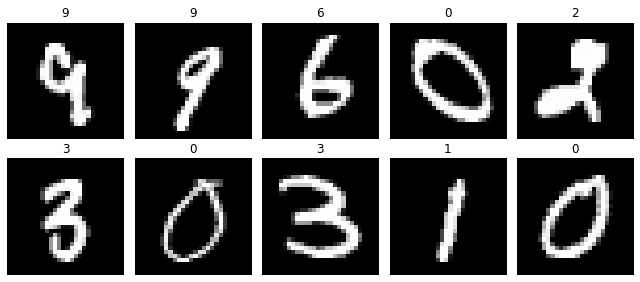

In [9]:
# --- Параметры ---
BATCH_SIZE = 64

# --- Преобразования ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# --- Загрузка MNIST ---
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

# --- Разделение на train/val ---
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_set, val_set = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"[INFO] Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_dataset)}")

# --- Примеры изображений ---
samples, labels = next(iter(train_loader))
plt.figure(figsize=(9, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.title(f"{labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
# --- Архитектура трансформера ---
class VisionTransformer(nn.Module):
    def __init__(self, input_size, num_classes, embed_dim=128, heads=4, layers=3, dropout=0.1, max_len=50):
        super().__init__()
        self.patch_proj = nn.Linear(input_size, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, embed_dim))

        encoder_block = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_block, num_layers=layers)
        self.head = nn.Linear(embed_dim, num_classes)
        self.attn_cache = []

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.unfold(2, 7, 7).unfold(3, 7, 7).contiguous().view(b, -1, 49)

        x = self.patch_proj(x)
        x = x + self.pos_embed[:, :x.size(1), :]

        encoded = self.encoder(x)

        self.attn_cache = []
        for block in self.encoder.layers:
            _, weights = block.self_attn(encoded, encoded, encoded, need_weights=True)
            self.attn_cache.append(weights.detach())

        return self.head(encoded.mean(dim=1))

model = VisionTransformer(input_size=49, num_classes=10).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO] Model initialized | Trainable params: {n_params}")


[INFO] Model initialized | Trainable params: 608906


In [11]:
# --- Обучение и валидация ---
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    loss_total, correct, count = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if is_train: optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)

        if is_train:
            loss.backward()
            optimizer.step()

        loss_total += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        count += y.size(0)

    return loss_total / len(loader), 100. * correct / count


In [12]:
# --- Основной цикл ---
EPOCHS = 10
LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_hist, val_hist = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, criterion)

    train_hist.append((train_loss, train_acc))
    val_hist.append((val_loss, val_acc))

    print(f"[{epoch+1:02d}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

test_loss, test_acc = run_epoch(model, test_loader, criterion)
print(f"[RESULT] Test Accuracy: {test_acc:.2f}%")


[01] Train Acc: 83.26% | Val Acc: 93.37%
[02] Train Acc: 94.95% | Val Acc: 95.72%
[03] Train Acc: 95.98% | Val Acc: 96.42%
[04] Train Acc: 96.48% | Val Acc: 96.88%
[05] Train Acc: 96.97% | Val Acc: 97.55%
[06] Train Acc: 97.09% | Val Acc: 97.60%
[07] Train Acc: 97.19% | Val Acc: 97.12%
[08] Train Acc: 97.35% | Val Acc: 96.67%
[09] Train Acc: 97.42% | Val Acc: 97.05%
[10] Train Acc: 97.70% | Val Acc: 97.38%
[RESULT] Test Accuracy: 97.51%


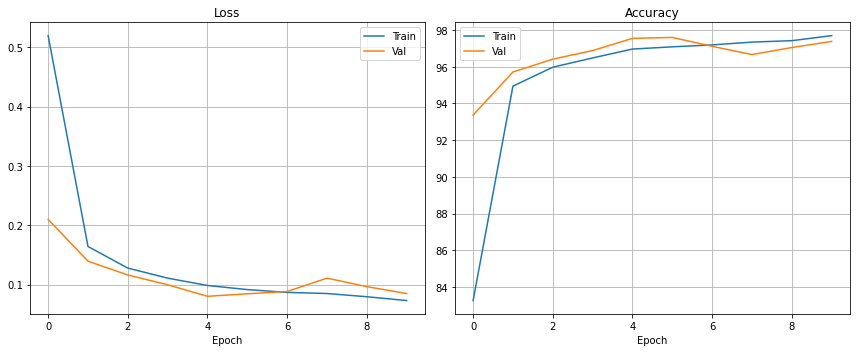

In [14]:
# --- Визуализация прогресса ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([x[0] for x in train_hist], label="Train")
plt.plot([x[0] for x in val_hist], label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([x[1] for x in train_hist], label="Train")
plt.plot([x[1] for x in val_hist], label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

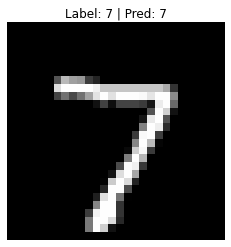

[ATTN] Visualizing attention for prediction 7


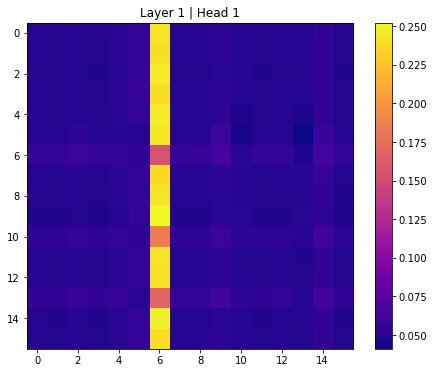

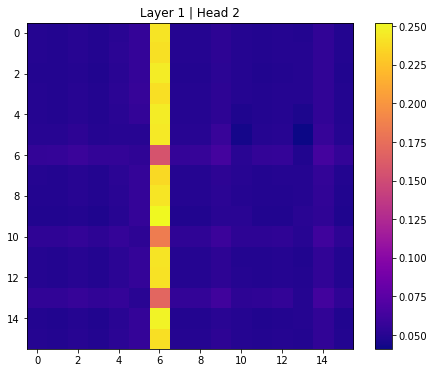

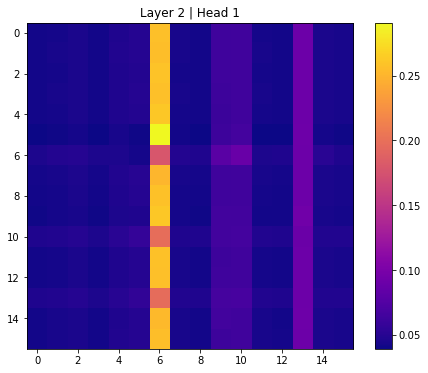

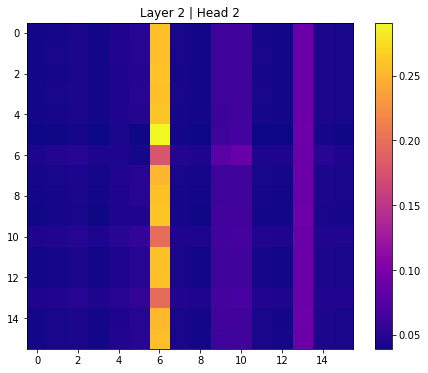

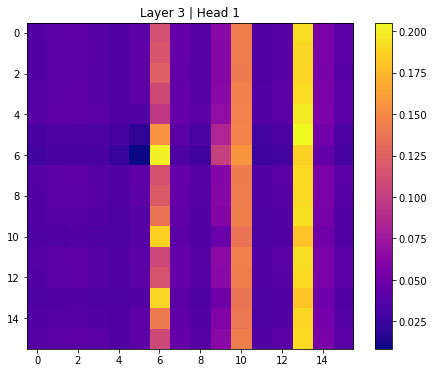

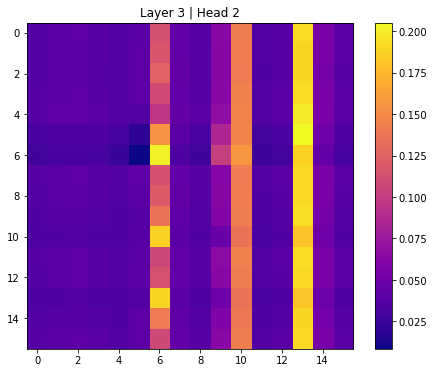

In [15]:
# --- Внимание ---
def show_attention(model, img, layer=0, head=0):
    model.eval()
    with torch.no_grad():
        _ = model(img.unsqueeze(0).to(device))
        weights = model.attn_cache[layer]
        if weights.ndim == 4:
            attn = weights[0, head].cpu().numpy()
        else:
            attn = weights[0].cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(attn, cmap="plasma")
    plt.colorbar()
    plt.title(f"Layer {layer+1} | Head {head+1}")
    plt.show()

def demo_attention(model, loader):
    x, y = next(iter(loader))
    img, label = x[0], y[0]

    pred = model(img.unsqueeze(0).to(device)).argmax(1).item()

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Label: {label} | Pred: {pred}")
    plt.axis("off")
    plt.show()

    print(f"[ATTN] Visualizing attention for prediction {pred}")

    num_layers = len(model.attn_cache)
    num_heads = model.encoder.layers[0].self_attn.num_heads

    for l in range(num_layers):
        for h in range(min(2, num_heads)):
            try:
                show_attention(model, img, l, h)
            except Exception as e:
                print(f"Skipped Layer {l}, Head {h} - Error: {e}")

demo_attention(model, test_loader)


На первых двух слоях заметны вертикальные акценты — это может указывать на то, что модель особенно чувствительна к вертикальным компонентам символа (в случае с цифрой 7 — это основная наклонная черта).

Горизонтальные элементы также проявляются, но не столь выражено — возможно, модель регистрирует наличие горизонтальной перекладины, но придаёт ей меньший вес.

На третьем уровне появляются ярко выраженные участки ближе к центру attention-матрицы. Это может отражать механизм связывания между различными патчами — вероятно, речь идёт об объединении фрагментов (например, горизонтальной и наклонной линии) в целостную структуру.

Как трансформер "смотрит" на цифру
Слой 1: Извлекает базовые визуальные признаки — границы, изгибы, линии.

Слой 2: Формирует более крупные визуальные паттерны — части символов, переходы между ними.

Слой 3: Производит интеграцию информации — модель, вероятно, "собирает" символ целиком и сравнивает с эталонными шаблонами.

Таким образом, наблюдается характерная для трансформеров прогрессивная агрегация: от локальных признаков к глобальному семантическому пониманию. 
